<a href="https://colab.research.google.com/github/andrewsiyoon/spiking-seRNN/blob/main/DVSGesture_RSNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
pip install tonic

In [2]:
%%capture
!git clone https://github.com/jeshraghian/snntorch
%cd snntorch
!python3 setup.py install

In [3]:
#Imports -----

import torch, torch.nn as nn
import snntorch as snn
import numpy as np
import scipy 
import tonic

import random

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns

In [4]:
#Random seeds -----

random.seed(211)
torch.manual_seed(211)

In [5]:
#DVS Gesture -----

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset

from torch.utils.data import DataLoader

#Define variables (batch size, sensor size)
batch_size = 64
data_path = '/data/DVSGesture'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sensor_size = tonic.datasets.DVSGesture.sensor_size

#Define transformations
frame_transform = tonic.transforms.Compose([transforms.Denoise(filter_time=10000), transforms.ToFrame(sensor_size=sensor_size, n_time_bins = 20)])

#Define training and test sets
DVS_train = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
DVS_test = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

#Create cached sets
cached_trainset = DiskCachedDataset(DVS_train, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(DVS_test, cache_path='./cache/DVSGesture/test')

#Create dataloaders
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True, drop_last = True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), drop_last = True)

In [6]:
#Initialize membrane time constant distribution -----

tau_mem = 20e-3
dist_shape = 3
time_step = 0.5e-3

def clip_tc(x):
    clipped_tc = x.clamp_(0.7165, 0.995)
    return clipped_tc

def init_tc():
    dist_gamma = np.random.gamma(dist_shape, tau_mem / 3, 100)
    dist_beta = torch.from_numpy(np.exp(-time_step / dist_gamma))
    clipped_beta = clip_tc(dist_beta)
    return clipped_beta

In [7]:
#Model architecture -----

from snntorch import surrogate

#Size parameters
num_inputs = 128*128*2
num_hidden = 100
num_outputs = 11

#Network parameters
het_tau = init_tc().to(device)
hom_tau = 0.9753

#Optimization mechanism
spike_grad = surrogate.fast_sigmoid()

#Model definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.RLeaky(beta = het_tau, linear_features = num_hidden, learn_beta = True, spike_grad = spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta = hom_tau, spike_grad = spike_grad)

    def forward(self, x):

        #Initialize parameters
        spk1, mem1 = self.lif1.init_rleaky() #init_rleaky() creates a tuple [_SpikeTensor, _SpikeTensor], assigns each to mem1 and spk1
        mem2 = self.lif2.init_leaky() #init_leaky() creates a tensor _SpikeTensor 

        #Record final layer
        spk_rec = []
        mem_rec = []

        #Forward loop
        for step in range(data.size(0)): #Iterate over the number of time steps in each mini-batch
            batched_data = data[step].view(batch_size, num_inputs) #Reshape input tensor to [batch_size, num_inputs]
            cur1 = self.fc1(batched_data)
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk_rec.append(spk2)
            mem_rec.append(mem2)

        #Convert final lists to tensors
        spk_rec = torch.stack(spk_rec)
        mem_rec = torch.stack(mem_rec)
        
        return spk_rec, mem_rec

net = Net().to(device)

Text(0.5, 0, 'ms')

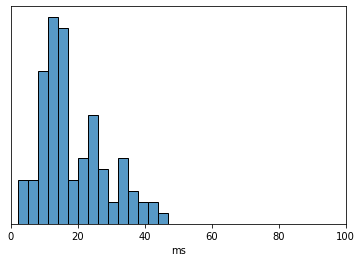

In [8]:
#Model visualizations (pre-training) -----  

# #All layers and associated parameters
# for name, param in net.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

#Membrane time constant distribution
#Define plot + parameters
tau = (-time_step / np.log(het_tau.cpu())) / 1e-3
fig, ax = plt.subplots()
tc_distribution = sns.histplot(data = tau, kde = False, ax = ax, binwidth = 3)

#Set x-axis limit and remove y-axis
ax.set_xlim(0,100)
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('ms')

In [9]:
#Optimizer and loss function -----

import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, betas = (0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate = 0.8, incorrect_rate = 0.2)

In [10]:
#Distance matrix -----

network_structure = [5, 5, 4]
distance_metric = 'euclidean'
distance_power = 1

nx = np.arange(network_structure[0])
ny = np.arange(network_structure[1])
nz = np.arange(network_structure[2])

[x,y,z] = np.meshgrid(nx,ny,nz)
coordinates = [x.ravel(),y.ravel(),z.ravel()]

euclidean_vector = scipy.spatial.distance.pdist(np.transpose(coordinates), metric=distance_metric)
euclidean = scipy.spatial.distance.squareform(euclidean_vector**distance_power)
distance_matrix = euclidean.astype('float32')

distance_matrix = torch.from_numpy(distance_matrix).to(device)

In [11]:
#Diagnostic tests -----

from scipy.stats import pearsonr

#Test for spatial regularization
def test_euclidean(x, y):
    x = torch.abs(x)
    x_array = x.cpu().detach().numpy()
    flat_x_array = x_array.flatten()
    y = torch.abs(y)
    y_array = y.cpu().detach().numpy()
    flat_y_array = y_array.flatten()
    correlation = pearsonr(flat_x_array, flat_y_array)[0]
    return correlation

print(f"Initial correlation between distance and weight matrices: {test_euclidean(distance_matrix, net.lif1.recurrent.weight)}")

Initial correlation between distance and weight matrices: -0.00720281738029272


In [12]:
#Training paradigm -----

#Training parameters
num_epochs = 50

#Regularization parameters
regu_strength = 0.5

#Initialize loss, accuracy, mean weights
loss_hist = []
acc_hist = []
feed_tot_hist = []
rec_tot_hist = []
corr_hist = []

#Pre-training extractions
acc_hist.append(0)
feed_tot_hist.append(torch.sum(torch.abs(net.fc1.weight.data)))
rec_tot_hist.append(torch.sum(torch.abs(net.lif1.recurrent.weight.data)))
corr_hist.append(test_euclidean(distance_matrix, net.lif1.recurrent.weight))

#Training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):

        #Load on CUDA (if available)
        data = data.to(device)
        targets = targets.to(device)

        #Set model to training mode
        net.train()
        outputs, _ = net(data)

        #Spatial + L1 regularization
        abs_weight_matrix = torch.abs(net.lif1.recurrent.weight).to(device)
        spatial_L1_loss = regu_strength * torch.sum(torch.mul(abs_weight_matrix, distance_matrix))

        #Calculate loss
        loss_val = loss_fn(outputs, targets) + spatial_L1_loss

        #Gradient calculation and weight updates
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        clip_tc(net.lif1.beta.data)

        #Store loss history
        loss_hist.append(loss_val.item())

    #Evaluations (every epoch)
    net.eval()

    #Report training loss
    print(f"Epoch {epoch} \nTraining Loss: {loss_val.item():.2f}")

    #Training accuracy
    acc = SF.accuracy_rate(outputs, targets) #Outputs: [num_steps, batch_size, num_outputs]. Targets: [batch_size]
    acc_hist.append(acc)
    print(f"Training accuracy: {acc * 100:.2f}%")

    #Sum of feedforward weights
    feed_tot = torch.sum(torch.abs(net.fc1.weight.data))
    feed_tot_hist.append(feed_tot)
    print(f"Total feedforward weight: {feed_tot}")

    #Sum of recurrent weights
    rec_tot = torch.sum(torch.abs(net.lif1.recurrent.weight.data))
    rec_tot_hist.append(rec_tot)
    print(f"Total recurrent weight: {rec_tot}")

    #Correlation of distance and weight matrices
    corr_matrices = test_euclidean(distance_matrix, net.lif1.recurrent.weight)
    corr_hist.append(corr_matrices)
    print(f"Correlation of distance and weight matrices: {corr_matrices}\n")

Epoch 0 
Training Loss: 554.58
Training accuracy: 28.12%
Total feedforward weight: 15258.00390625
Total recurrent weight: 359.47808837890625
Correlation of distance and weight matrices: -0.02119602784637397

Epoch 1 
Training Loss: 370.53
Training accuracy: 35.94%
Total feedforward weight: 17755.265625
Total recurrent weight: 240.27700805664062
Correlation of distance and weight matrices: -0.03263684790581105

Epoch 2 
Training Loss: 222.77
Training accuracy: 57.81%
Total feedforward weight: 18697.17578125
Total recurrent weight: 144.8975830078125
Correlation of distance and weight matrices: -0.054525784313297916

Epoch 3 
Training Loss: 112.88
Training accuracy: 45.31%
Total feedforward weight: 19232.6328125
Total recurrent weight: 74.74337768554688
Correlation of distance and weight matrices: -0.09688011424686517

Epoch 4 
Training Loss: 41.92
Training accuracy: 62.50%
Total feedforward weight: 19738.794921875
Total recurrent weight: 29.883766174316406
Correlation of distance and wei

In [13]:
#Diagnostic: accuracy function -----

# x, y = outputs.sum(dim=0).max(1)
# print(y)
# print(targets)
# accuracy = np.mean((targets == y).detach().cpu().numpy())
# print(accuracy)

In [14]:
#Test set accuracy -----

total = 0
correct = 0
dataloader = testloader

with torch.no_grad():
  net.eval()
  for data, targets in dataloader:
    data = data.to(device)
    targets = targets.to(device)

    #Forward pass
    test_spk, _ = net(data)

    #Calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 165/256
Test Set Accuracy: 64.45%


Layer: fc1.weight | Size: torch.Size([100, 32768]) | Values : Parameter containing:
tensor([[ 0.0107,  0.0013, -0.0021,  ..., -0.0073, -0.0013,  0.0093],
        [ 0.0108,  0.0097,  0.0047,  ..., -0.0024, -0.0057,  0.0036],
        [ 0.0191,  0.0164, -0.0004,  ..., -0.0005,  0.0033,  0.0017],
        ...,
        [-0.0023, -0.0101, -0.0006,  ..., -0.0024,  0.0011,  0.0028],
        [ 0.0025,  0.0076, -0.0035,  ..., -0.0044, -0.0014, -0.0006],
        [ 0.0015, -0.0112,  0.0136,  ..., -0.0019, -0.0126, -0.0305]],
       device='cuda:0', requires_grad=True) 

Layer: fc1.bias | Size: torch.Size([100]) | Values : Parameter containing:
tensor([-0.0016,  0.0320, -0.0034, -0.0370, -0.0047, -0.0497,  0.0371,  0.0558,
        -0.0117,  0.0305, -0.0077, -0.0102, -0.0033, -0.0076, -0.0216,  0.0516,
         0.0171, -0.0081,  0.0476,  0.0747,  0.0612, -0.0141,  0.0013,  0.0115,
        -0.0057, -0.0100,  0.0053, -0.0199,  0.0148,  0.0725, -0.0133,  0.0122,
        -0.0489, -0.0026, -0.0267,  0.041

Text(0.5, 0, 'ms')

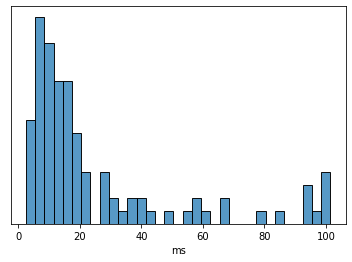

In [15]:
#Model visualizations (post-training) -----

#All layers and associated parameters
for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

#Membrane time constant distribution
#Define plot + parameters
tau = (-time_step / np.log(net.lif1.beta.data.cpu())) / 1e-3
fig, ax = plt.subplots()
tc_distribution = sns.histplot(data = tau, kde = False, ax = ax, binwidth = 3)

#Visual modifications
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('ms')

In [16]:
feed_tot_hist = torch.FloatTensor(feed_tot_hist)
rec_tot_hist = torch.FloatTensor(rec_tot_hist)
corr_hist = torch.FloatTensor(corr_hist)

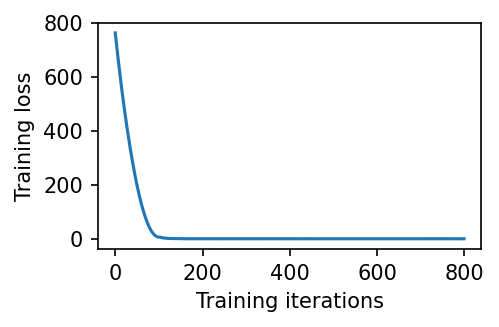

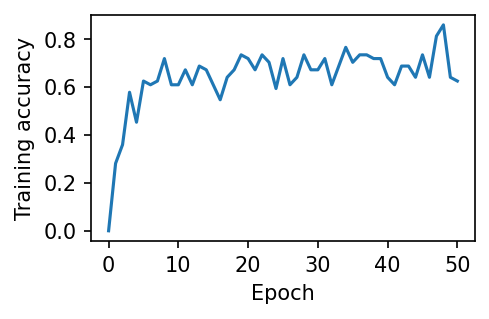

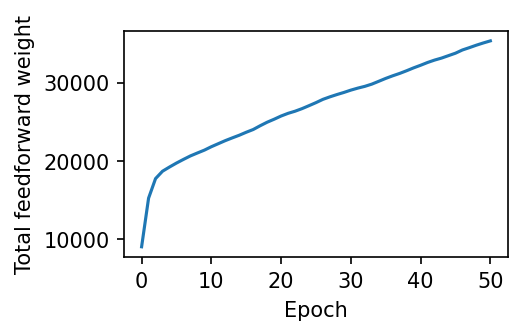

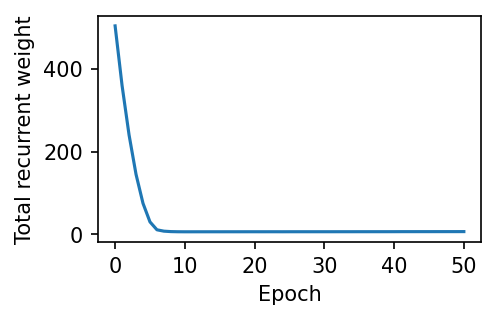

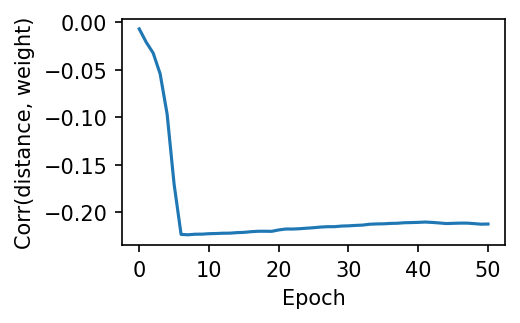

In [17]:
#Data visualizations -----

#Loss
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel('Training iterations')
plt.ylabel('Training loss')
plt.savefig('training_loss')

#Accuracy/performance
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.savefig('training_accuracy')

#Total feedforward weight
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(feed_tot_hist)
plt.xlabel('Epoch')
plt.ylabel('Total feedforward weight')
plt.savefig('total_feedforward_weight')

#Total recurrent weight
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(rec_tot_hist.cpu())
plt.xlabel('Epoch')
plt.ylabel('Total recurrent weight')
plt.savefig('total_recurrent_weight')

#Correlation of distance/weight matrices
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(corr_hist.cpu())
plt.xlabel('Epoch')
plt.ylabel('Corr(distance, weight)')
plt.savefig('correlation')